## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №18

#### Прогноз просрочки кредита заемщиком
Набор данных представляет собой исторические данные по 251503 заемщикам (https://www.kaggle.com/c/GiveMeSomeCredit/data ).  
Задача является бинарной классификацией. Цель - предсказать будет ли тот или иной заемщик испытывать финансовые трудности в ближайшие 2 года, т.е. будет ли просрочка по займу. Выборка разделена на тренировочную и тестовую ( 150000 в тренировочной части, 101503 в тестовой).

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
#from tqdm import tqdm_notebook as tqdm

from math import nan

%matplotlib inline
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve, learning_curve

RANDOM_STATE = 17

In [2]:
# Генерация файла результатов
def make_submission(predictions, fname):
    out = pd.DataFrame(data=predictions, columns=['Probability'])
    out.index += 1
    out.to_csv(fname, index_label='id')

In [124]:
df = pd.read_csv('cs-training.csv', index_col=0)

col_dict = {
    # Целевая метка (1/0): будет ли просрочка платежей более 90 дней в ближайшие 2 года, Да/Нет
    'SeriousDlqin2yrs':'Delinquency',  
    # Баланс по кредитам (%): сумма всех кредитов за исключением недвижимости и рассрочек(автокредиты), разделенная на сумму кредитных лимитов
    'RevolvingUtilizationOfUnsecuredLines':'CreditBalance',
    # Возраст заемщика (лет)
    'age':'Age',
    # Количество просрочек платежей за последние 2 года: от 30 до 59 дней
    'NumberOfTime30-59DaysPastDueNotWorse':'Delay30-59',
    # Коэффициент задолженности (%): отношение суммы ежемесячных платежей (долги, алименты, проживание) к месячному доходу
    'DebtRatio':'DebtRatio',
    # Mесячный доход ($)
    'MonthlyIncome':'MonthlyIncome',
    # Количество открытых кредитов (рассрочек) и кредитных линий (кредитные карты)
    'NumberOfOpenCreditLinesAndLoans':'CreditLineNum',
    # Количество просрочек платежей за последние 2 года: 90 дней и больше
    'NumberOfTimes90DaysLate':'Delay90',
    # Количество открытых кредитов на недвижимость, включая кредитные линии под залог жилья
    'NumberRealEstateLoansOrLines':'EstateLoanNum',
    # Количество просрочек платежей за последние 2 года: от 60 до 89 дней
    'NumberOfTime60-89DaysPastDueNotWorse':'Delay60-89',
    # Количество иждивенцев в семье (исключая заемщика)
    'NumberOfDependents':'Dependents'
} 

df.columns = [col_dict.get(x,x) for x in df.columns]

df = df[['Age','Dependents','MonthlyIncome','DebtRatio','CreditBalance','CreditLineNum','EstateLoanNum','Delay30-59','Delay60-89','Delay90','Delinquency']]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Age            150000 non-null  int64  
 1   Dependents     146076 non-null  float64
 2   MonthlyIncome  120269 non-null  float64
 3   DebtRatio      150000 non-null  float64
 4   CreditBalance  150000 non-null  float64
 5   CreditLineNum  150000 non-null  int64  
 6   EstateLoanNum  150000 non-null  int64  
 7   Delay30-59     150000 non-null  int64  
 8   Delay60-89     150000 non-null  int64  
 9   Delay90        150000 non-null  int64  
 10  Delinquency    150000 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


In [125]:
# Для признака Dependents заменить все пустые значения на -1
df['Dependents'].fillna(-1, inplace=True)
# Для признака MonthlyIncome заменить все пустые значения на 0
df['MonthlyIncome'].fillna(0, inplace=True)

In [126]:
print(f'Количество записей-дубликатов: {df[df.duplicated()].shape[0]}')

# Удалить дубликаты сохраняя первую запись
df = df.drop_duplicates(keep='first')
print(f'Набор данных после удаления дубликатов: {df.shape}')

Количество записей-дубликатов: 648
Набор данных после удаления дубликатов: (149352, 11)


In [129]:
df.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,149352.0,NaN,NaN,NaN,52.310153,14.722797,0.0,41.0,52.0,63.0,109.0
Dependents,149352.0,NaN,NaN,NaN,0.714935,1.136387,-1.0,0.0,0.0,1.0,20.0
MonthlyIncome,149352.0,NaN,NaN,NaN,5370.84578,13176.007265,0.0,1600.0,4400.0,7400.0,3008750.0
IncomeCategory,149352,1,unknown,149352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DebtRatio,149352.0,NaN,NaN,NaN,354.529267,2042.102001,0.0,0.177571,0.368293,0.875665,329664.0
CreditBalance,149352.0,NaN,NaN,NaN,6.072551,250.296329,0.0,0.03015,0.154239,0.556414,50708.0
CreditLineNum,149352.0,NaN,NaN,NaN,8.482786,5.135809,0.0,5.0,8.0,11.0,58.0
EstateLoanNum,149352.0,NaN,NaN,NaN,1.022658,1.130222,0.0,0.0,1.0,2.0,54.0
Delay30-59,149352.0,NaN,NaN,NaN,0.392676,3.836862,0.0,0.0,0.0,0.0,98.0
Delay60-89,149352.0,NaN,NaN,NaN,0.211246,3.794182,0.0,0.0,0.0,0.0,98.0


Проверьте наличие категориальных признаков, а также соответствие содержимого данных их типам

In [135]:
# Ваш код здесь
df.nunique(axis=0)

Age                   86
Dependents            14
MonthlyIncome      13594
IncomeCategory         9
DebtRatio         114194
CreditBalance     125728
CreditLineNum         58
EstateLoanNum         28
Delay30-59            16
Delay60-89            13
Delay90               19
Delinquency            2
dtype: int64

In [128]:
df.insert(3,'IncomeCategory', 'unknown')

In [134]:
df.head()

,Age,Dependents,MonthlyIncome,IncomeCategory,DebtRatio,CreditBalance,CreditLineNum,EstateLoanNum,Delay30-59,Delay60-89,Delay90,Delinquency
1,45,2.0,9120.0,upto10000,0.802982,0.766127,13,6,2,0,0,1
2,40,1.0,2600.0,upto3000,0.121876,0.957151,4,0,0,0,0,0
3,38,0.0,3042.0,upto5000,0.085113,0.658180,2,0,1,0,1,0
4,30,0.0,3300.0,upto5000,0.036050,0.233810,5,0,0,0,0,0
5,49,0.0,63588.0,upto100000,0.024926,0.907239,7,1,1,0,0,0


In [133]:
# Добавить признак категории месячного дохода
#df.insert(3,'IncomeCategory', 'unknown')
df.loc[(df.MonthlyIncome>0) & (df.MonthlyIncome<=3000), 'IncomeCategory'] = 'upto3000' 
df.loc[(df.MonthlyIncome>3000) & (df.MonthlyIncome<=5000), 'IncomeCategory'] = 'upto5000' 
df.loc[(df.MonthlyIncome>5000) & (df.MonthlyIncome<=7500), 'IncomeCategory'] = 'upto7500' 
df.loc[(df.MonthlyIncome>7500) & (df.MonthlyIncome<=10000), 'IncomeCategory'] = 'upto10000' 
df.loc[(df.MonthlyIncome>10000) & (df.MonthlyIncome<=20000), 'IncomeCategory'] = 'upto20000' 
df.loc[(df.MonthlyIncome>20000) & (df.MonthlyIncome<=50000), 'IncomeCategory'] = 'upto50000' 
df.loc[(df.MonthlyIncome>50000) & (df.MonthlyIncome<=100000), 'IncomeCategory'] = 'upto100000'
df.loc[(df.MonthlyIncome>100000), 'IncomeCategory'] = 'over100000' 

In [111]:
df['Age'].value_counts()

49     3834
48     3798
50     3747
47     3719
46     3708
       ... 
102       3
109       2
107       1
105       1
0         1
Name: Age, Length: 86, dtype: int64

<AxesSubplot: >

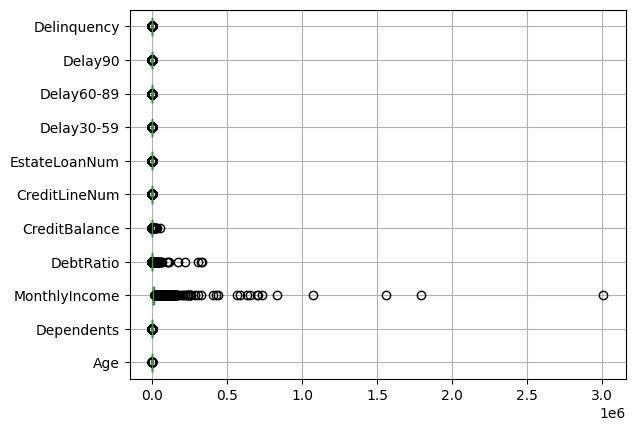

In [50]:
df.boxplot(vert=0 )

In [92]:
df['MonthlyIncome'] = round(df['MonthlyIncome']/1000)*1000

#df_raw[['Fuel_Price']] = df_raw[['Fuel_Price']].round(2).astype('float32')

Проверьте наличие NaN, при необходимости осуществите замену

In [57]:
# Ваш код здесь 

О чем свидетельствуют пропуски в данных, чем их лучше заменить? Осуществите необходимую замену...

In [9]:
# Ваш код здесь

Оцените количество вернувших и не вернувших кредит. Какую метрику лучше всего использовать?

In [51]:
# Ваш код здесь
df['Delinquency'].value_counts()

0    139382
1     10009
Name: Delinquency, dtype: int64

Проверьте качество замены переменных

In [11]:
# Ваш код здесь

__Визуализация данных__

Используя  seaborn.pairplot (sns) визуализируйте данные

In [12]:
# Ваш код здесь

Используя sns.heatmap постройте корреляционную матрицу

In [13]:
# Ваш код здесь

Какие существуют зависимости в данных?
Опишите зависимости каждого из признаков!

In [14]:
# Описание здесь

__Предобработка данных__

Оцените распределение признаков. Удалите коррелированные! Выберите способ нормализации. Подготовьте данные для обучения выбранных моделей...

In [15]:
# Ваш код здесь

__Выбор метрики__

В качестве метрики используется ROC-AUC score, согласно соренованию. Данная метрика подходит для данной задачи, так как мы хотим определять тех заемщиков, которые сильно задержат выплату кредита, но при этом выдавать кредиты хорошим клиентам. Также эта метрика хорошо работает со случаем несбалансированных классов (как в нашем случае).
Выберите способ перекрестной проверки! Какой из них подходит наилучшим образом...

In [16]:
# Ваш код здесь

Обучите 2 классификатора логистическую регрессию и случайный лес.
Для визуализации процесса обучения используйте прогрессбар tqdm

In [17]:
# Ваш код здесь

Оцените среднюю правильность выбранной модели

In [18]:
# Ваш код здесь

__Кросс-валидация и подбор параметров__

Произведите подбор параметров. Для логистической регрессии подберем коэффициент регуляризции, для случайного леса -максимальную глубину и максимальное кол-во признаков. Для отслеживания процесса обучения используйте прогрессбар, а также %%time

In [19]:
# Ваш код здесь

Отобразите результаты обучения модели

In [20]:
# Ваш код здесь

Какая из моделей показала наилучшие результаты? Отобразите подобранные параметры.

In [21]:
# Ваш код здесь

Данная модель дает результат 0.860890 на public leaderboard и 0.864706 на private.

__Создание новых признаков__

1. Выберите признаки подлежащие бинаризации.
2. Осуществите бинаризацию.
3. Как влияет количество интервалов бинаризации на качество модели? 

Для создания новых признаков рекомендую ответить на следующие вопросы:
Как влияют количество иждевенцев у заемщика на просрочку выплат?
Какой тип кредитов чаще всего берет заемщик?

In [23]:
 # Ваш код здесь

Как улучшилось качество модели?

In [ ]:
# Описание здесь

__Кривые валидации и обучения__

In [ ]:
# Постройте кривые валидации и обучения

Какие наилучшие параметры модели по результатам построения?
Как можно улучшить модель?

In [24]:
# Описание здесь

__Оценка модели с описанием выбранной метрики__

__Общие выводы__

По результатам проведенного анализа, можно увидеть, что есть определенные зависимости и признаки просрочки кредита. 
Наблюдаются следующие закономерности - ...

Имеет влияние .... - с ростом ..., заемщик становиться менее привлекательным в связи с высокой вероятностью новой просрочки.

Также влияет и количество ... заемщика - клиент ... не выплачивает кредит вовремя. 

В дальнейшем, можно добавить новые признаки (.... и т.д.)
Также можно заменить случайный лес на ...